Amatya Pathak       
May 9th, 2023       
CS-UY 3943 BK07 Mining Massive Datasets

Final Project: Creating a Music Genre Predictor in an Increasingly Genre-Defying Soundscape
<hr>

Music spans the breadth of human identity and experience, and so naturally there exist countless categories of songs and pieces. In our globalized world, new genres are constantly forming and merging, and song placement into one or more of these categories is increasingly debatable.

But that doesn't stop us from trying. After all, there is high demand and incentive to categorize music to best cater to millions of music streaming service subscribers.

Humans can easily identify song genres within seconds of hearing a new piece of music. This categorization allows us to group songs by genre and create organized music playlists and libraries. _How well can machine learning automate this?_
<hr>

Advanced recommendation algorithms powering streaming services like Spotify rely on various song metadata to quantitatively identify song genres. This project uses the __Spotipy API__ to retrieve the songs and their metadata, which includes both __acoustic features__ (like loudness, tempo, key) and what Spotify calls __"psychoacoustic" features__ (like Danceability, Energy, Instrumentalness, Liveness, Valence). All of these metrics are on a 0-1 scale.

This project adds one more strategy to better classify genres; it creates a __mel spectrogram__ for each song. This will be explained in more detail, but it is basically an image generated from the transformed and scaled waveform of a song. This contains a more complete outlook of the song's compositon beyond the summarizing metrics, and can thus improve model accuracy.

All this song feature data can be fed into the appropriate genre directories for training. To keep things simple, this iteration of the project has only __10 genre__ folders to put songs into. For each genre, an large subset of an appropriate Spotify playlist will be selected (for example, the Hip-Hop category will be trained on the popular Spotify-curated playlist "RapCaviar"). The ten genres in the Spotify part of the project are:
1. rap/hip-hop
2. blues
3. classical
4. country
5. electronic dance music (EDM)
6. metal
7. pop
8. reggaeton
9. qawwali
10. rock

Due to Spotify's ToS and the lack of good datasets with genres 5, 8, and 9, these are excluded from the second mel-spectrogram phase.

Four machine learning models will be tested for performance and accuracy on the test subset of the plain this project: __logistic regression (LR)__, __random forest (RF)__, __k-nearest neighbors (KNN)__, and a __decision tree (DT)__. Then they will be tested on a random subset of a large varied playlist, of which there will be two copies (one Spotify and one YouTube) so both strategies can be equally assessed. We can also observe performance with genre-defying songs and aspects that the model wasn't trained on (different song languages and instruments, for example)

Let's get started!
<hr>

First, we need to install some dependencies...

In [1]:
#The star of the show
%pip install spotipy

#For working with/visualizing our data
%pip install pandas
%pip install matplotlib
%pip install seaborn

#Our source of ML models
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to us

...And import the required modules from those dependencies

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

After importing Spotipy, we need to register our program with Spotify's API and receive an access token. Note that in production environments, the id and secret would __never__ be displayed, and would be stored in a local file explicitly listed in .gitignore. Given the Colab testing environment, and the development mode of our program interfacing with Spotify API that requires every user to be preapproved, an exception is made.

In [3]:
CLIENT_ID = "9fc5467bc2bb4a17b75bd738e6537374"
CLIENT_SECRET = "4757bea69f7c408c9aae3b8a840fd1bb"

#Getting the Spotify API Access token
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,client_secret=CLIENT_SECRET))

Let's confirm that Spotipy initialization works and Spotify API granted us an access token. As a test, here are the top 10 songs returned when "The Weeknd" is searched:

In [4]:
results = sp.search(q='The Weeknd', limit=10)
for idx, track in enumerate(results['tracks']['items']):
    print(idx, track['name'])

0 Blinding Lights
1 One Of The Girls (with JENNIE, Lily Rose Depp)
2 The Hills
3 Save Your Tears
4 Starboy
5 Die For You
6 Stargirl Interlude
7 Die For You
8 Call Out My Name
9 Popular (with Playboi Carti & Madonna) - From The Idol Vol. 1 (Music from the HBO Original Series)


We have access! Now we can gather our training datasets per genre, using this function to create a dataframe with all the aforementioned features, then populate it with the playlist's songs. Here are the __psychoacoustic__ feature descriptions listed
- danceability
- energy
- loudness
- speechiness
- instrumentalness
- liveness (is there an audience in the recording?)
- valence  (positivity/happiness level)

Here we define a function to convert the raw data into usable dataframe format:

In [5]:
def analyze_playlist(creator, playlist_id, genre):

    # Blank dataframe
    playlist_features = ["artist","album","track_name", "track_id", "genre",                                                     #Metadata
                      "key","tempo", "duration_ms","time_signature", "mode",                                         #Acoustic Features
                      "danceability", "energy","loudness", "speechiness", "instrumentalness", "liveness", "valence"] #Psychoacoustic Features

    playlist_df = pd.DataFrame(columns = playlist_features)

    # Loop through every track in the playlist, extract features and append the features to the playlist df

    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]

    #Max 50 songs
    counter = 0
    for track in playlist:
        playlist_dict = {}

        # Populating metadata
        playlist_dict["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_dict["album"] = track["track"]["album"]["name"]
        playlist_dict["track_name"] = track["track"]["name"]
        playlist_dict["track_id"] = track["track"]["id"]
        playlist_dict["genre"] = int(genre)

        #Populating acoustic and psychoacoustic features
        audio_features = sp.audio_features(playlist_dict["track_id"])[0]
        #Somehow not all the acoustic/psychoacoustic parameters are stored as floats, we'll fix that here
        for feature in playlist_features[5:]:
            playlist_dict[feature] = float(audio_features[feature])


        # Concatenate all the track info to the overall playlist dataframe
        track_df = pd.DataFrame(playlist_dict, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        counter+=1
        if(counter>=50):
          break
    #We explicity want the genre to be numbered; just like everything that goes into an ML model
    playlist_df['genre'] = playlist_df['genre'].astype('int64')
    return playlist_df


Let's use this function to populate 10 dataframes, each containing one playlist genre's data:

In [6]:
#Populating all the dataframes takes time; the last recorded run was about 48 seconds
hiphop_df = analyze_playlist("spotify", "37i9dQZF1DX0XUsuxWHRQd",1)

blues_df = analyze_playlist("spotify", "37i9dQZF1DXd9rSDyQguIk", 2)

classical_df = analyze_playlist("spotify", "37i9dQZF1EQn1VBR3CMMWb", 3)

country_df = analyze_playlist("spotify", "37i9dQZF1EQmPV0vrce2QZ", 4)

edm_df = analyze_playlist("spotify", "37i9dQZF1EIhSskk1NQ9dI", 5)

metal_df = analyze_playlist("spotify", "37i9dQZF1EQpgT26jgbgRI", 6)

pop_df = analyze_playlist("spotify", "37i9dQZF1DXcBWIGoYBM5M", 7)

reggaeton_df = analyze_playlist("spotify", "37i9dQZF1DWY7IeIP1cdjF", 8)

qawwali_df = analyze_playlist("Irfan Moriya", "0USwGwasJVrHVN5Xkdhw0d", 9) #this genre is a type of folk music in West and South Asia, very soulful and instrumental

rock_df = analyze_playlist("spotify", "37i9dQZF1DWXRqgorJj26U", 10)


/tmp/ipykernel_18461/3567344939.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
/tmp/ipykernel_18461/3567344939.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
/tmp/ipykernel_18461/3567344939.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude emp

We can now begin to prepare a dataframe containing training data for our machine learning models to receive. Here we combine all the genre dataframes into one big dataframe and double check that the columns and data are apprpriately filled:

In [7]:
df_list = [hiphop_df, blues_df, classical_df, country_df, edm_df, metal_df, pop_df, reggaeton_df, qawwali_df, rock_df]
df = pd.concat(df_list)
df.columns= df.columns.str.replace(" ","_").str.lower()   #Columns should already have lowercase and no whitespace, but just in case
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 49
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            500 non-null    object 
 1   album             500 non-null    object 
 2   track_name        500 non-null    object 
 3   track_id          500 non-null    object 
 4   genre             500 non-null    int64  
 5   key               500 non-null    float64
 6   tempo             500 non-null    float64
 7   duration_ms       500 non-null    float64
 8   time_signature    500 non-null    float64
 9   mode              500 non-null    float64
 10  danceability      500 non-null    float64
 11  energy            500 non-null    float64
 12  loudness          500 non-null    float64
 13  speechiness       500 non-null    float64
 14  instrumentalness  500 non-null    float64
 15  liveness          500 non-null    float64
 16  valence           500 non-null    float64
dtypes: 

We can also see the correlations between the acoustic parameters before the ML models see them, via this heatmap:. For example, there is a positive correlation between loudness and energy, which makes intuitive sense.

<Axes: >

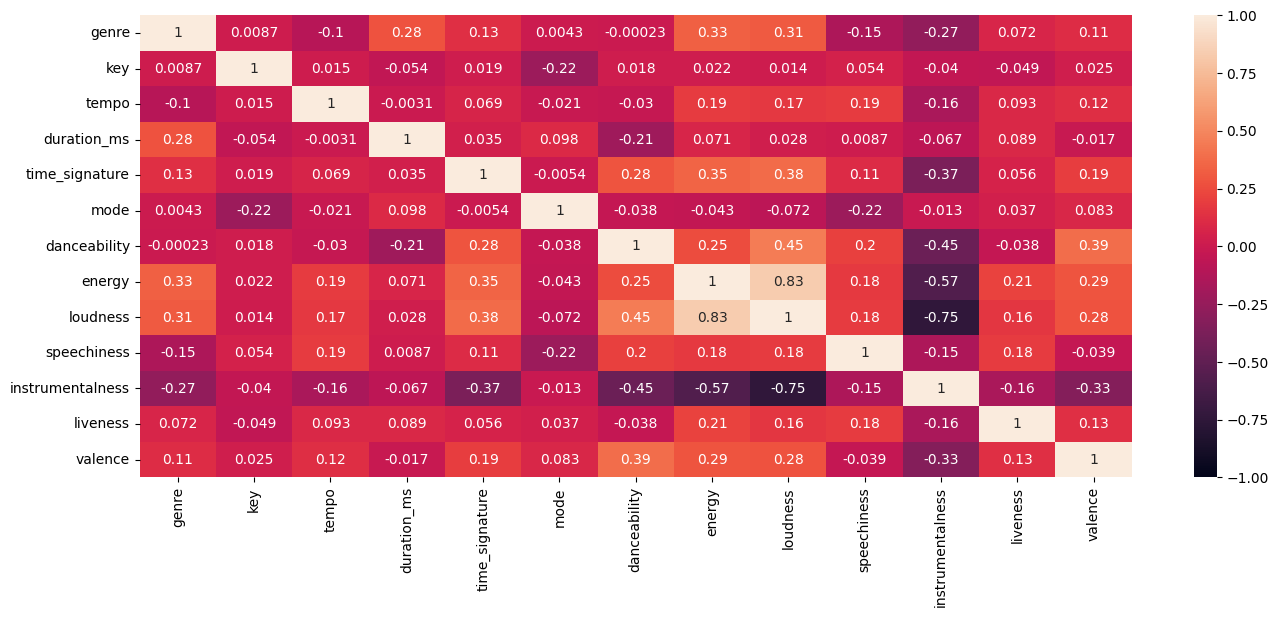

In [8]:
df_cont = df.select_dtypes([int,float]) #store all integer or float columns in df_cont variable

plt.figure(figsize=(16, 6)) #output figure size
sns.heatmap(data = df_cont.corr(), vmin = -1, vmax = 1, annot = True)

Let's start preparing the data for input into the models. First we convert the song names and title drop the column we want to predict (genre) and pass in the remainder of the dataframe as X, which in turn would be split into training (80%) and test (20%) data.
Then the dataframe is standardized and normalized (min max scale) as recommended by scikit-learn docs.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=["artist", "album", "track_name", "track_id","genre"], axis=1)
y = df["genre"]

#80:20 Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=None)

#The ML model docs recommend standardizing/normalizing our data on a 0-1 scale before inputting it:
scaler = StandardScaler()
stdnorm_x_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

scaler = MinMaxScaler()
stdnorm_x_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

Now let's start creating models to accurately classify our songs into the genres we defined, starting with perhaps the simplest one, logistic regression:

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

LR = LogisticRegression(solver='liblinear').fit(stdnorm_x_train, y_train)
normalized_x_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
y_pred = LR.predict(normalized_x_test)

LRAcc = accuracy_score(y_pred,y_test) # Calculate accuracy
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test Set RMSE: ",test_rmse)

Logistic Regression accuracy is: 51.00%
Test Set RMSE:  3.40440890610984


/home/amatya/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


With the logistic regression parameters specified above and after running 10 trials (only the random seed is changing), we get: <br>
Min accuracy: 47.4% <br>
Max accuracy: 57.0% <br>
Average accuracy: 51.9% <br>
This fluctuates based on the random state, however, and it seems that an 80/20 split yields the best results without overfitting.

Let's try another simple classification algorithm, the decision tree:

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

DTclassifier = DecisionTreeClassifier(max_leaf_nodes=75).fit(stdnorm_x_train, y_train)
y_pred = DTclassifier.predict(normalized_x_test)
DTAcc = accuracy_score(y_pred,y_test) # Calculating accuracy
print('Decision Tree accuracy is: {:.2f}%'.format(DTAcc*100))
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test Set RMSE: ",test_rmse)

Decision Tree accuracy is: 53.00%
Test Set RMSE:  2.9


/home/amatya/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Min accuracy: 49.3% <br>
Max accuracy: 57.7% <br>
Average accuracy: 54.5% <br>

A random forest is just an aggregation of multiple decision trees, so let's try that next:

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

RFC = RandomForestClassifier(n_estimators=75, random_state=None)

# Train the classifier on the training data
RFC.fit(X_train, y_train)

# Make predictions on the test data
y_pred = RFC.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test Set RMSE: ",test_rmse)

Accuracy: 62.00%
Test Set RMSE:  2.7964262908219126


/home/amatya/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


With the random forest parameters specified above, running 10 trials by only changing the random seed yields: <br>
Min accuracy: 62.1% <br>
Max accuracy: 69.0% <br>
Average accuracy: 65.9% <br>

It was also found that accuracy peaked at 69% with 55 estimators, with slight decreases in accuracy if the number of estimators is greater or less than this.

Now let's check out the KNN model's performance. 

Since there are a lot more hyperparameters and values to experiment with, we'll start by making and testing models of various hyperparameters using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), and find which configurations yield the highest accuracy. 

Then we can comment the GridSearchCV section out and simply make a model with the best hyperparameters we found.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],
    'max_iter': [100, 200, 300, 400, 500]
}

# Create a KMeans object
kmeans = KMeans()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(kmeans, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Use the best hyperparameters to train the final KMeans model
best_kmeans = KMeans(n_clusters=grid_search.best_params_['n_clusters'],
                     max_iter=grid_search.best_params_['max_iter'])
best_kmeans.fit(X_train)

# Get cluster labels for the test data
y_pred = best_kmeans.predict(X_test)

# Calculate the accuracy score
silhouette_avg = silhouette_score(X_test, y_pred)
print("Accuracy score: ", silhouette_avg*100, "%")
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test Set RMSE: ",test_rmse)

Best hyperparameters:  {'max_iter': 100, 'n_clusters': 6}
Best accuracy score:  0.0925
Accuracy score:  52.47375003066623 %
Test Set RMSE:  4.716990566028302


/home/amatya/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Min accuracy: 50.1% <br>
Max accuracy: 52.3% <br>
Average accuracy: 51.5% <br>

Finally, lets evaluate the SVM's performance as well. Note that we are using the LinearSVC (support vector classification) class from sckit-learn here, which only differs from the SVC class in its kernel (linear instead of RBF). This should help our LinearSVC model variants (each with slightly different hyperparameters) retain high accuracy with larger datasets. 

Similar to the KNN test, we'll make and test various models of different hyperparameters with GridSearchCV, and find which hyperparameters yield the highest accuracy models. Then we can comment the GridSearchCV section out and make a model with the best hyperparameters we found.

Check out the [LinearSVC Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) for more information.

In [ ]:
from sklearn.svm import LinearSVC
'''
#Testing various combinations of different parameters to find the one with the highest accuracy:
paramgrid2 = {
    'penalty': ['l1','l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': ['auto', 'bool'],
    'C': [0.5, 1.0, 2],
    'multi_class': ['ovr', 'crammer_singer']
}

SVMmodel = LinearSVC()
# Use GridSearchCV to find the best hyperparameters
grid_search2 = GridSearchCV(SVMmodel, param_grid=paramgrid2, scoring='accuracy')
grid_search2.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Best hyperparameters: ", grid_search2.best_params_)
print("Best accuracy score: ", grid_search2.best_score_)

'''
#The best combination was found to be the following, with accuracy ~ 52.5% (runtime ~ 18 minutes)
#{'C': 0.5, 'dual': 'auto', 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}
SVMmodel = LinearSVC(penalty='l1', loss='squared_hinge', dual='auto', C=0.32, multi_class='ovr')
SVMmodel.fit(X_train, y_train)
# Make predictions on the test data
y_pred = SVMmodel.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test Set RMSE: ",test_rmse)


Min accuracy: 57.1% <br>
Max accuracy: 60.2% <br>
Average accuracy: 58.2% <br>

<hr>
Now that we've trained several models on Spotify's song data (random-forest being the most accurate so far), the ideal continuation is to train a model on the same playlists using the mel-spectrogram approach.

Unfortunately, Spotify's API does not have enough information to generate a spectrogram, nor allows song clip downloading to make one. We'll have to use a different dataset for that, called [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download).

A mel-spectrogram is simply a visualization of the soundwave amplitudes of a song, after applying a fast Fourier transform to change the scale from time to frequency, and scaling the upper and lower frequencies to better match the perception of the human ear (mel scale).

We'll use the Kaggle API to obtain the GTZAN dataset. First you need to generate your own API key through your Kaggle account settings and store the resulting .json file in the ~/.kaggle/ folder (C\Users\USERNAME\\.kaggle for Windows). Then we need to pip install Kaggle:

In [ ]:
%pip install kaggle

Now we can download the GTZAN dataset, and then extract the zipfile to our working directory:

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

In [ ]:
import zipfile
with zipfile.ZipFile("gtzan-dataset-music-genre-classification.zip", 'r') as zipref:
    zipref.extractall()

The next step is to organize our image data into training and test sets. Let's start by creating test and train folders in the working directory:

In [ ]:
import os
import random
import shutil

os.makedirs("Dataset", exist_ok=True)
os.makedirs("Dataset/train", exist_ok=True)
os.makedirs("Dataset/test", exist_ok=True)


For the 7 genres that are present in both the Spotify and GTZAN datasets, the genre folders were randomly shuffled and then partitioned into 80% training and 20% test sets, as shown below.

In [ ]:
import os
import random
import shutil
genres = ['blues', 'classical', 'country', 'pop', 'hiphop', 'metal','rock']
datasetpath = "Data/images_original"
trainingpath = "Dataset/train"
testpath = "Dataset/test"
for g in genres:
  filenames = os.listdir(datasetpath+"/"+g)
  random.shuffle(filenames)
  numtraining = int(len(filenames) * 0.8) #number of training images per genre
  trainingfilenames = filenames[:numtraining]
  testfilenames = filenames[numtraining:]

  if(os.path.isdir(trainingpath+"/"+g) == False):   #We don't want to overwrite directory contents if we've already run this cell before
    os.makedirs(trainingpath+"/"+g, exist_ok=True)
    for f in trainingfilenames:
      originpath = datasetpath+"/"+g+"/"+f
      shutil.move(originpath, trainingpath+"/"+g)

  if(os.path.isdir(testpath+"/"+g) == False):       #We don't want to overwrite directory contents if we've already run this cell before
    os.makedirs(testpath+"/"+g, exist_ok=True)
    for f in testfilenames:
      originpath = datasetpath+"/"+g+"/"+f
      shutil.move(originpath, testpath+"/"+g)

  

Now using the TensorFlow library, we can load the image datasets in a format usable for TensorFlow ML models:

In [ ]:
%pip install tensorflow

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (432, 288) # image size (from opening an image's metadata)
traindata = tf.keras.preprocessing.image_dataset_from_directory(directory=trainingpath,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical") # type of classification we're doing
                                                                         
testdata = tf.keras.preprocessing.image_dataset_from_directory(directory=testpath,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Now we create, compile, and fit a simple neural network model:

In [ ]:
#Creating the model
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(10),
    #tf.keras.layers.Dropout(0.5),#Extra layer added to reduce overfitting
    tf.keras.layers.Dense(7, activation="softmax") # binary activation output
])

# Compiling the model
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fitting the model
halftestdata = testdata.__len__()//2
validata = testdata.take(halftestdata) #half of the test set (10% of total)
history1 = model1.fit(traindata, epochs=20, validation_data=validata)

To visualize how the loss and accuracy of the model changes over time (epochs), let's make a small function that simplifies the graphing:

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  accuracy = history.history['accuracy']
  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
plot_loss_curves(history1)

Looks like the model is learning! Let's see how it does on the test dataset, which the model has never seen before:

In [ ]:
model1.evaluate(testdata)

This simple neural network seems to get about 60% accuracy in identifying a song's genre from the mel spectrogram. Which is better than guessing (1/7 or ~14.3% accuracy), but there are ways to do better. Let's try one more model: a convolutional nerual network (CNN). CNN's are especially suited to image processing and learning.

In [ ]:
#Creating the model
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 4, activation='relu', input_shape=(432, 288, 3)),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(8, 4, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(7, activation='softmax')
])

# Compiling the model
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fitting the model
history2 = model2.fit(traindata, epochs=15, validation_data=validata)

How are the loss and accuracy curves over the epochs?

In [ ]:
plot_loss_curves(history2)

And how does the model do on unseen mel spectrograms?

In [ ]:
model2.evaluate(testdata)

On unseen spectrograms, the model guesses the music genre with about 70% accuracy on average, maxing as high as 78%! This is our best model so far out of all options explored, and by addressing the slight overfitting (as seen in the lower val accuracy metrics per epoch), even higher accuracy can be reached.

In conclusion, we have tested logistic regression, random forest, KNN, SVM, and a simple decision tree through scikit-learn as simple ML approaches to classify song genres, and we tried both a simple fully connected neural network and a convolutional neural network (CNN) through TensorFlow. It turns out we saved the best model for last, as in terms of accuracy, the CNN reached an unbeatable 70.71% accuracy on average in class prediction. The models shown here can serve as a baseline to compare future improvements to, and better classify the music we listen to. Hope you found this notebook informative and helpful!